# 🚚 E-Commerce Shipping Analytics - 배송 지연 예측 프로젝트

---

## 0. 데이터셋 소개

| 항목 | 내용 |
|------|------|
| **데이터셋** | E-Commerce Shipping Dataset (Kaggle) |
| **샘플 수** | 10,999건 |
| **목표** | 고객 주문의 **배송 지연 여부** 예측 (이진 분류) |
| **타겟 변수** | `Reached.on.Time_Y.N` → 1: 정시 도착, 0: 배송 지연 |

## 1. 데이터셋 소개 <a id='0-데이터셋-소개'></a>

**데이터 명세 (Data Dictionary)**
총 10,999개의 데이터와 12개의 컬럼으로 구성되어 있습니다.

| 구분 | 컬럼명 | 설명 | 데이터 타입 | 비고 |
|:---:|:---|:---|:---:|:---|
| **Target** | `Reached.on.Time_Y.N` | 배송 지연 여부 (1: 정시 도착, 0: 지연) | int64 | **Target Variable** |
| **Index** | `ID` | 고유 식별자 | int64 | 분석 시 제거 예정 |
| **Categorical** | `Warehouse_block` | 창고 구역 (A, B, C, D, F) | object | |
| | `Mode_of_Shipment` | 배송 수단 (Ship, Flight, Road) | object | |
| | `Product_importance` | 제품 중요도 (low, medium, high) | object | |
| | `Gender` | 고객 성별 (F, M) | object | |
| **Numerical** | `Customer_care_calls` | 고객센터 전화 횟수 | int64 | |
| | `Customer_rating` | 고객 만족도 (1~5) | int64 | |
| | `Cost_of_the_Product` | 제품 가격 | int64 | |
| | `Prior_purchases` | 이전 구매 횟수 | int64 | |
| | `Discount_offered` | 제공된 할인율 | int64 | **핵심 변수** |
| | `Weight_in_gms` | 제품 무게 (g) | int64 | **핵심 변수** |

### 분석 파이프라인

1. 라이브러리 임포트 & 데이터 로딩
2. 탐색적 데이터 분석 (EDA) — 다변량 시각화
3. 전처리 — boolean 타겟, 원핫인코딩, 다운캐스팅
4. 특성 공학 — 파생변수 생성
5. 다중 모델링 & Optuna 하이퍼파라미터 튜닝
6. 모델 평가 & 해석


---
## 1. 라이브러리 임포트 & 데이터 로딩


In [45]:
import warnings
warnings.filterwarnings('ignore')

# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler

# 모델링
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                               VotingClassifier, StackingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 평가 지표
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# 하이퍼파라미터 튜닝
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
optuna.logging.set_verbosity(optuna.logging.WARNING)

# SHAP
try:
    import shap
    SHAP_AVAILABLE = True
    print("✅ SHAP 사용 가능")
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP 미설치 — SHAP 분석 건너뜀")

# 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("✅ 라이브러리 로드 완료!")


✅ SHAP 사용 가능
✅ 라이브러리 로드 완료!


In [ ]:
# ===== 데이터 로드 =====
import os

# 경로 설정 — 본인 환경에 맞게 수정하세요
data_path = os.path.join('data', 'Train.csv')

# 대체 경로 시도
alt_paths = [
    r'C:\Users\User\github\Ecom_Shipping\data\Train.csv',
    '../data/Train.csv',
    'Train.csv',
    'data/Train.csv'
]

df = None
for p in [data_path] + alt_paths:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f"✅ 데이터 로드 성공: {p}")
        break

if df is None:
    raise FileNotFoundError("Train.csv를 찾을 수 없습니다. data_path를 수정해주세요.")

print(f"📊 데이터 크기: {df.shape[0]:,}행 × {df.shape[1]}열")
print(f"💾 메모리 사용: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\n📋 컬럼 목록:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col:30s} | {str(df[col].dtype):8s} | 결측: {df[col].isnull().sum()}")

df.head()


✅ 데이터 로드 성공: C:\Users\User\github\Ecom_Shipping\data\Train.csv
📊 데이터 크기: 10,999행 × 12열
💾 메모리 사용: 3.18 MB

📋 컬럼 목록:
   1. ID                             | int64    | 결측: 0
   2. Warehouse_block                | object   | 결측: 0
   3. Mode_of_Shipment               | object   | 결측: 0
   4. Customer_care_calls            | int64    | 결측: 0
   5. Customer_rating                | int64    | 결측: 0
   6. Cost_of_the_Product            | int64    | 결측: 0
   7. Prior_purchases                | int64    | 결측: 0
   8. Product_importance             | object   | 결측: 0
   9. Gender                         | object   | 결측: 0
  10. Discount_offered               | int64    | 결측: 0
  11. Weight_in_gms                  | int64    | 결측: 0
  12. Reached.on.Time_Y.N            | int64    | 결측: 0


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [ ]:
# 기본 정보
print("=" * 60)
print("📊 데이터 타입 & 결측치")
print("=" * 60)
print(df.dtypes)
print(f"\n결측치 합계: {df.isnull().sum().sum()}")
print("\n📈 기초 통계량:")
df.describe()


📊 데이터 타입 & 결측치
ID                      int64
Warehouse_block        object
Mode_of_Shipment       object
Customer_care_calls     int64
Customer_rating         int64
Cost_of_the_Product     int64
Prior_purchases         int64
Product_importance     object
Gender                 object
Discount_offered        int64
Weight_in_gms           int64
Reached.on.Time_Y.N     int64
dtype: object

결측치 합계: 0

📈 기초 통계량:


,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


---
## 3. 탐색적 데이터 분석 (EDA) — 상세 시각화

> **목표**: 최대한 많은 컬럼들의 상관관계를 이해할 수 있는 시각화


### 3.1 타겟 변수 분석


타겟 분포:
Reached.on.Time_Y.N
1    6563
0    4436
Name: count, dtype: int64

비율:
Reached.on.Time_Y.N
1    0.5967
0    0.4033
Name: proportion, dtype: float64


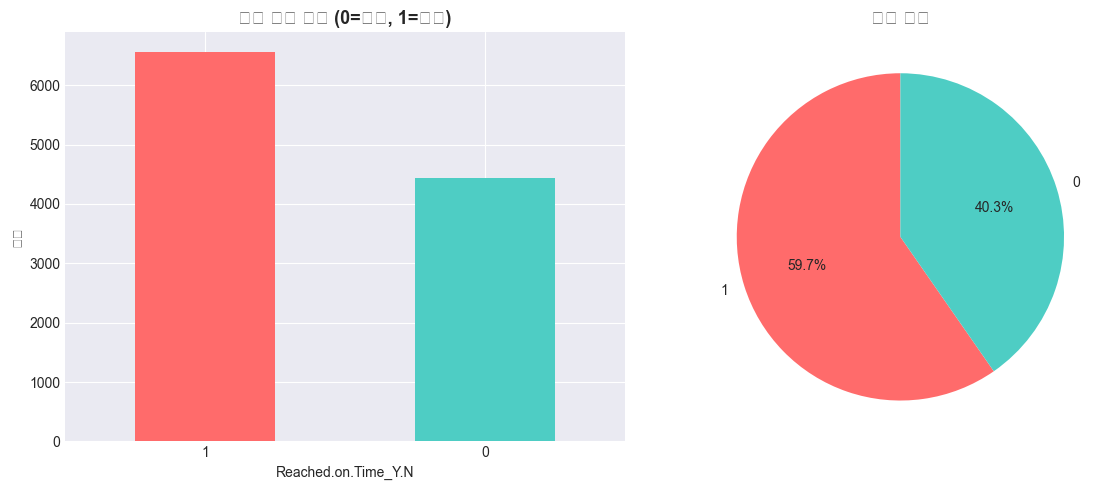

In [ ]:
target_col = 'Reached.on.Time_Y.N'

print(f"타겟 분포:\n{df[target_col].value_counts()}")
print(f"\n비율:\n{df[target_col].value_counts(normalize=True).round(4)}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = ['#FF6B6B', '#4ECDC4']

df[target_col].value_counts().plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('타겟 변수 분포 (0=지연, 1=정시)', fontsize=13, weight='bold')
axes[0].set_ylabel('건수')
axes[0].tick_params(rotation=0)

df[target_col].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                    colors=colors, startangle=90)
axes[1].set_title('타겟 비율', fontsize=13, weight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


### 3.1 타겟 변수(`Reached.on.Time_Y.N`) 분포 분석

데이터 분석의 첫 단계로, 우리가 예측해야 할 정답값(Label)의 비율을 확인합니다.

* **클래스 불균형 확인**: 정시 도착(1)과 배송 지연(0)의 비율이 한쪽으로 극단적으로 치우쳐져 있다면, 모델 학습 시 `class_weight` 조정이나 오버샘플링(SMOTE) 등의 조치가 필요할 수 있습니다.
* **베이스라인 정확도**: 만약 정시 도착 비율이 60%라면, 무조건 "정시 도착"이라고 찍는 모델의 기본 정확도가 60%가 됩니다. 우리의 머신러닝 모델은 이 수치를 넘어서야 의미가 있습니다.

### 3.2 수치형 변수 분포 & 박스플롯


수치형 변수 (6개): ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']


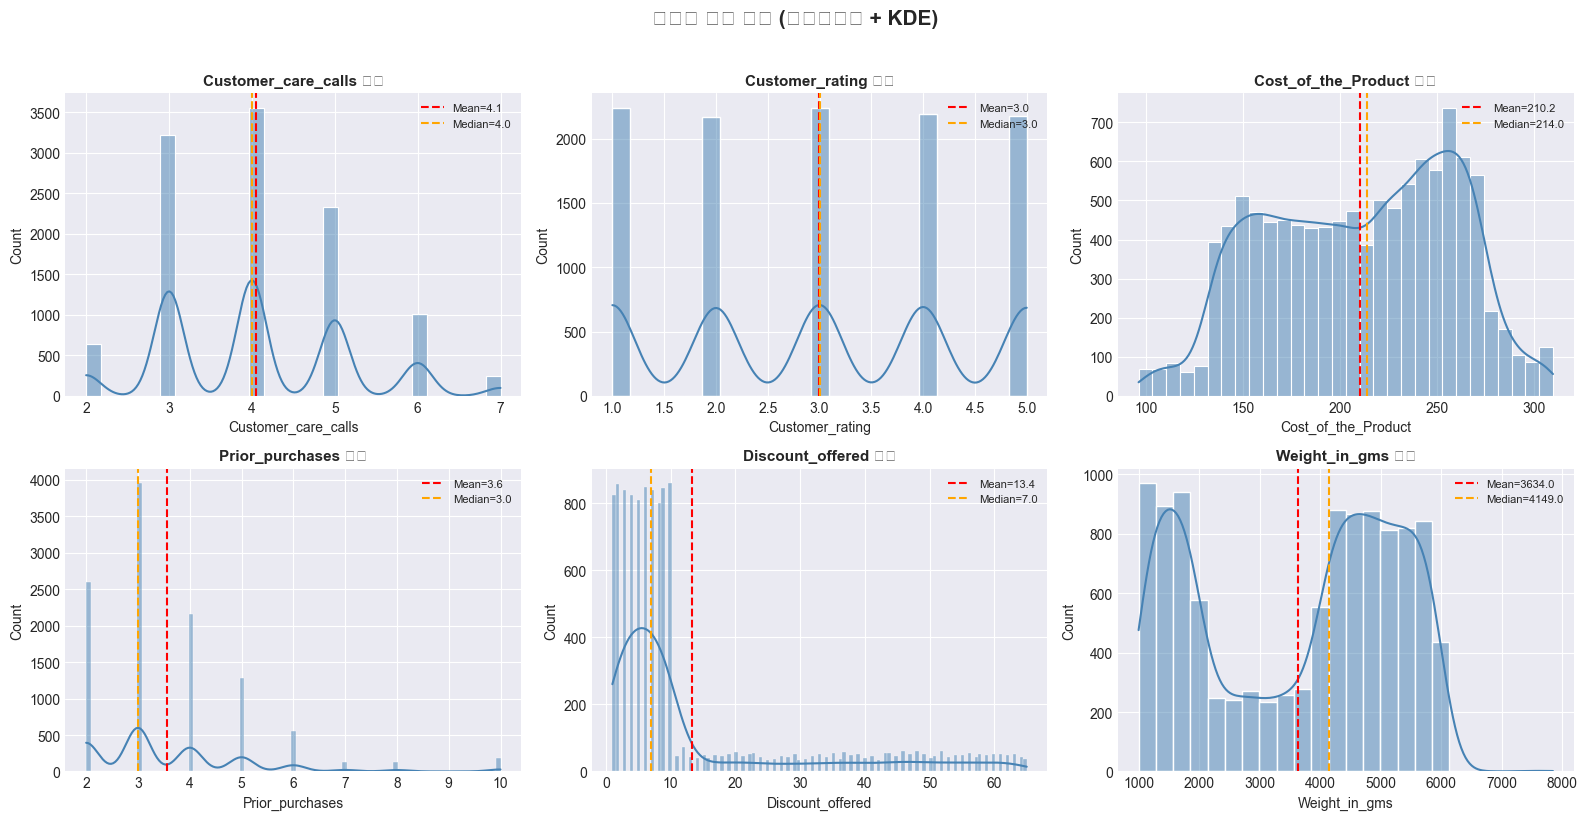

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['ID', target_col]]

print(f"수치형 변수 ({len(numeric_cols)}개): {numeric_cols}")

# 히스토그램 + KDE
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[idx], color='steelblue', edgecolor='white')
    axes[idx].set_title(f'{col} 분포', fontsize=11, weight='bold')
    axes[idx].axvline(df[col].mean(), color='red', ls='--', label=f'Mean={df[col].mean():.1f}')
    axes[idx].axvline(df[col].median(), color='orange', ls='--', label=f'Median={df[col].median():.1f}')
    axes[idx].legend(fontsize=8)

for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('수치형 변수 분포 (히스토그램 + KDE)', fontsize=15, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 3.2 수치형 변수 분포 (Histogram & KDE)

수치형 데이터들의 분포 형태를 파악하여 데이터의 특성을 이해합니다.

* **정규분포 여부**: `Weight_in_gms`나 `Cost_of_the_Product` 등이 종 모양(Bell-curve)의 정규분포를 따르는지, 아니면 한쪽으로 치우친(Skewed) 분포인지 확인합니다. 치우친 데이터는 로그 변환(Log Transform)이 모델 성능 향상에 도움이 될 수 있습니다.
* **이상치(Outlier) 탐지**: 그래프의 양 끝단에 동떨어진 데이터가 있는지 시각적으로 확인합니다.

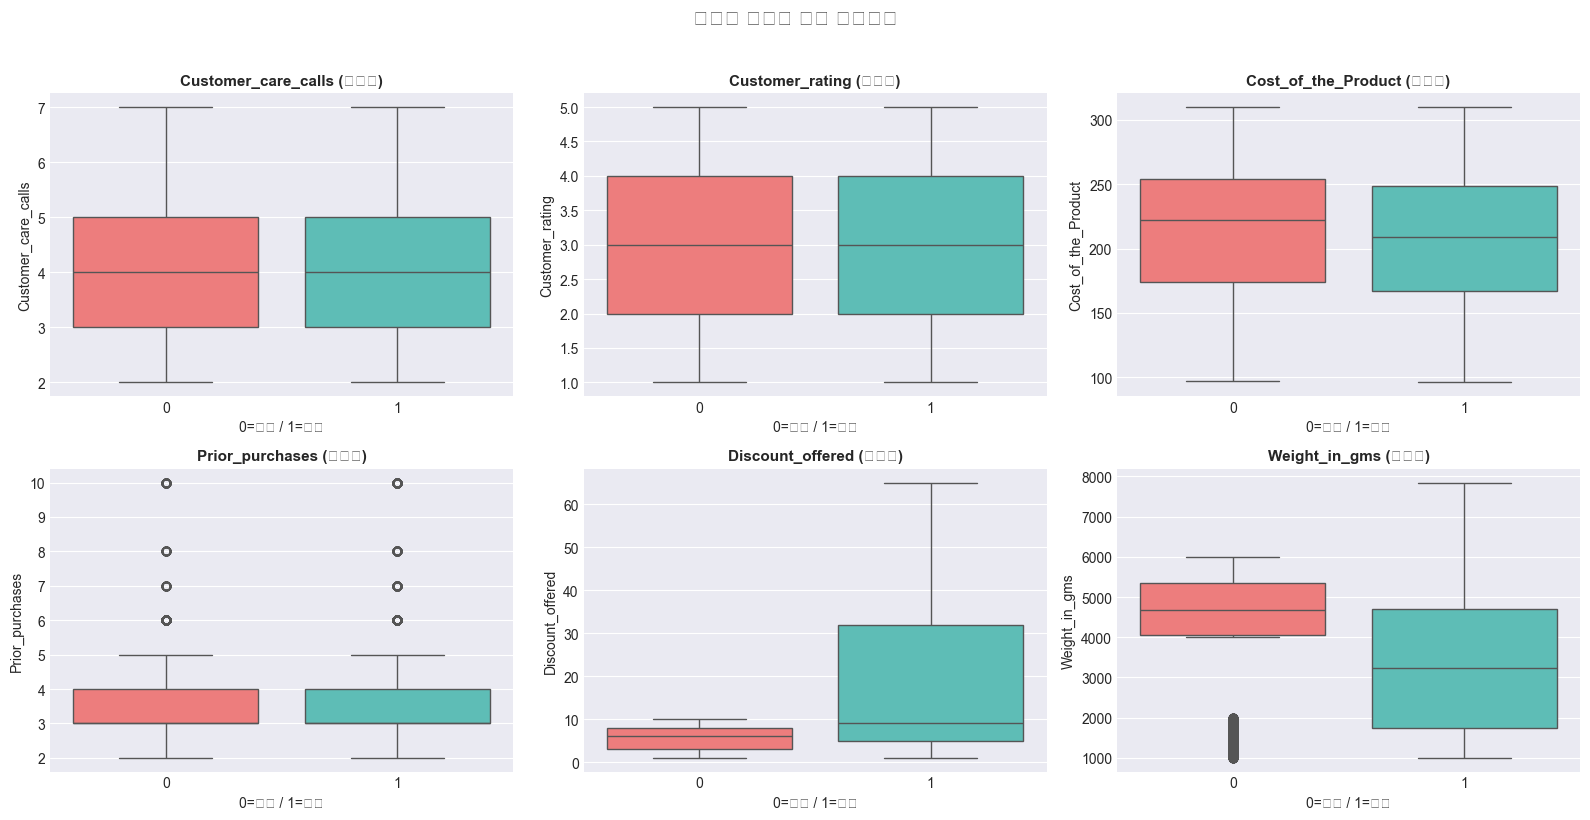

In [ ]:
# 박스플롯 — 타겟별 비교
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x=target_col, y=col, ax=axes[idx],
                palette=colors, showfliers=True)
    axes[idx].set_title(f'{col} (타겟별)', fontsize=11, weight='bold')
    axes[idx].set_xlabel('0=지연 / 1=정시')

for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('타겟별 수치형 변수 박스플롯', fontsize=15, weight='bold', y=1.02)
plt.tight_layout()
plt.show()


#### 📦 타겟별 변수 분포 비교 (Boxplot)

각 수치형 변수가 **배송 지연(0)과 정시 도착(1)을 얼마나 잘 구분해내는지** 확인하는 중요한 단계입니다.

* **해석 방법**: 두 박스(파란색 vs 붉은색)의 **높이 차이(중앙값의 차이)**가 클수록 해당 변수는 타겟을 분류하는 데 중요한 변수일 가능성이 높습니다.
* **예시**: 만약 `Discount_offered`의 박스 위치가 '지연' 그룹에서 현저히 높다면, "할인율이 높을수록 배송이 지연될 확률이 높다"는 가설을 세울 수 있습니다.

### 3.3 상관관계 분석


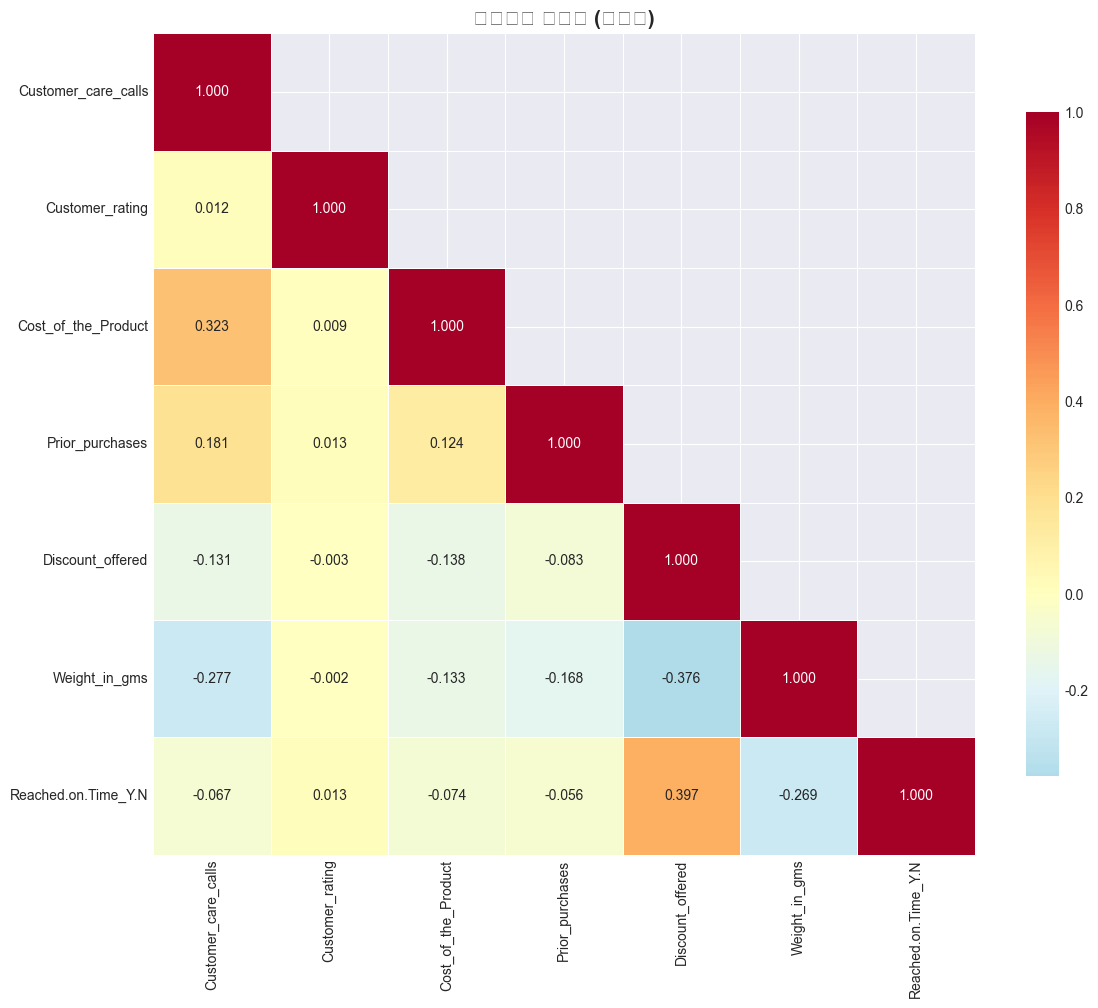


📊 타겟과의 상관관계 (절대값 순):
  Discount_offered               : +0.3971
  Weight_in_gms                  : -0.2688
  Cost_of_the_Product            : -0.0736
  Customer_care_calls            : -0.0671
  Prior_purchases                : -0.0555
  Customer_rating                : +0.0131


In [ ]:
# 전체 상관관계 히트맵
plt.figure(figsize=(12, 10))
corr_cols = numeric_cols + [target_col]
corr_matrix = df[corr_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r',
            center=0, square=True, linewidths=0.5, mask=mask,
            cbar_kws={"shrink": 0.8})
plt.title('상관관계 히트맵 (하삼각)', fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

print("\n📊 타겟과의 상관관계 (절대값 순):")
target_corr = corr_matrix[target_col].drop(target_col).abs().sort_values(ascending=False)
for feat, val in target_corr.items():
    direction = "+" if corr_matrix.loc[feat, target_col] > 0 else "-"
    print(f"  {feat:30s} : {direction}{val:.4f}")


Pairplot 변수: ['Discount_offered', 'Weight_in_gms', 'Cost_of_the_Product', 'Customer_care_calls']


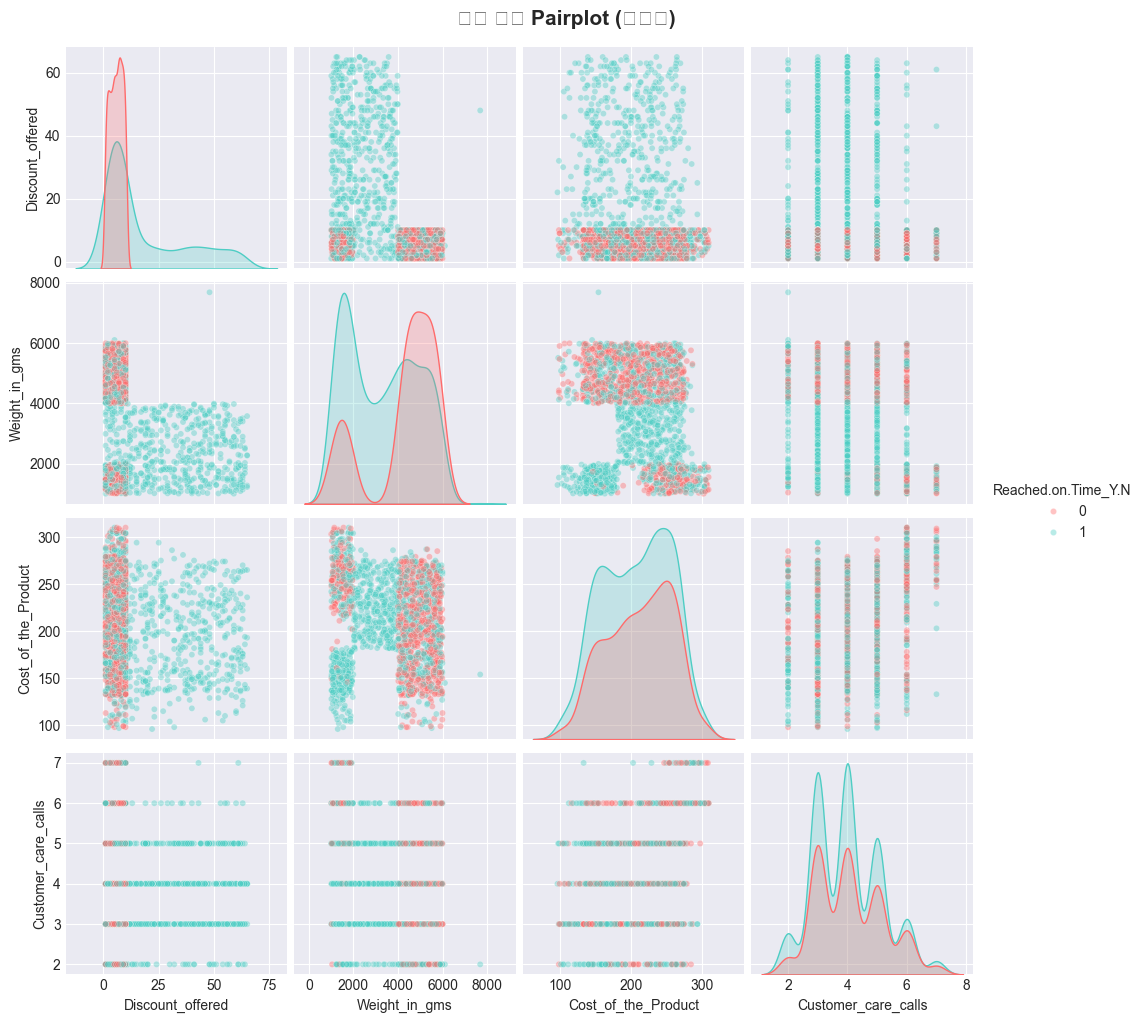

In [ ]:
# Pairplot — 주요 변수 + 타겟
key_vars = target_corr.head(4).index.tolist()
print(f"Pairplot 변수: {key_vars}")

g = sns.pairplot(df[key_vars + [target_col]].sample(min(2000, len(df)), random_state=42),
                 hue=target_col, palette=colors, diag_kind='kde',
                 plot_kws={'alpha': 0.4, 's': 20})
g.figure.suptitle('주요 변수 Pairplot (타겟별)', fontsize=15, weight='bold', y=1.02)
plt.show()


### 3.4 범주형 변수 분석


범주형 변수 (4개): ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']


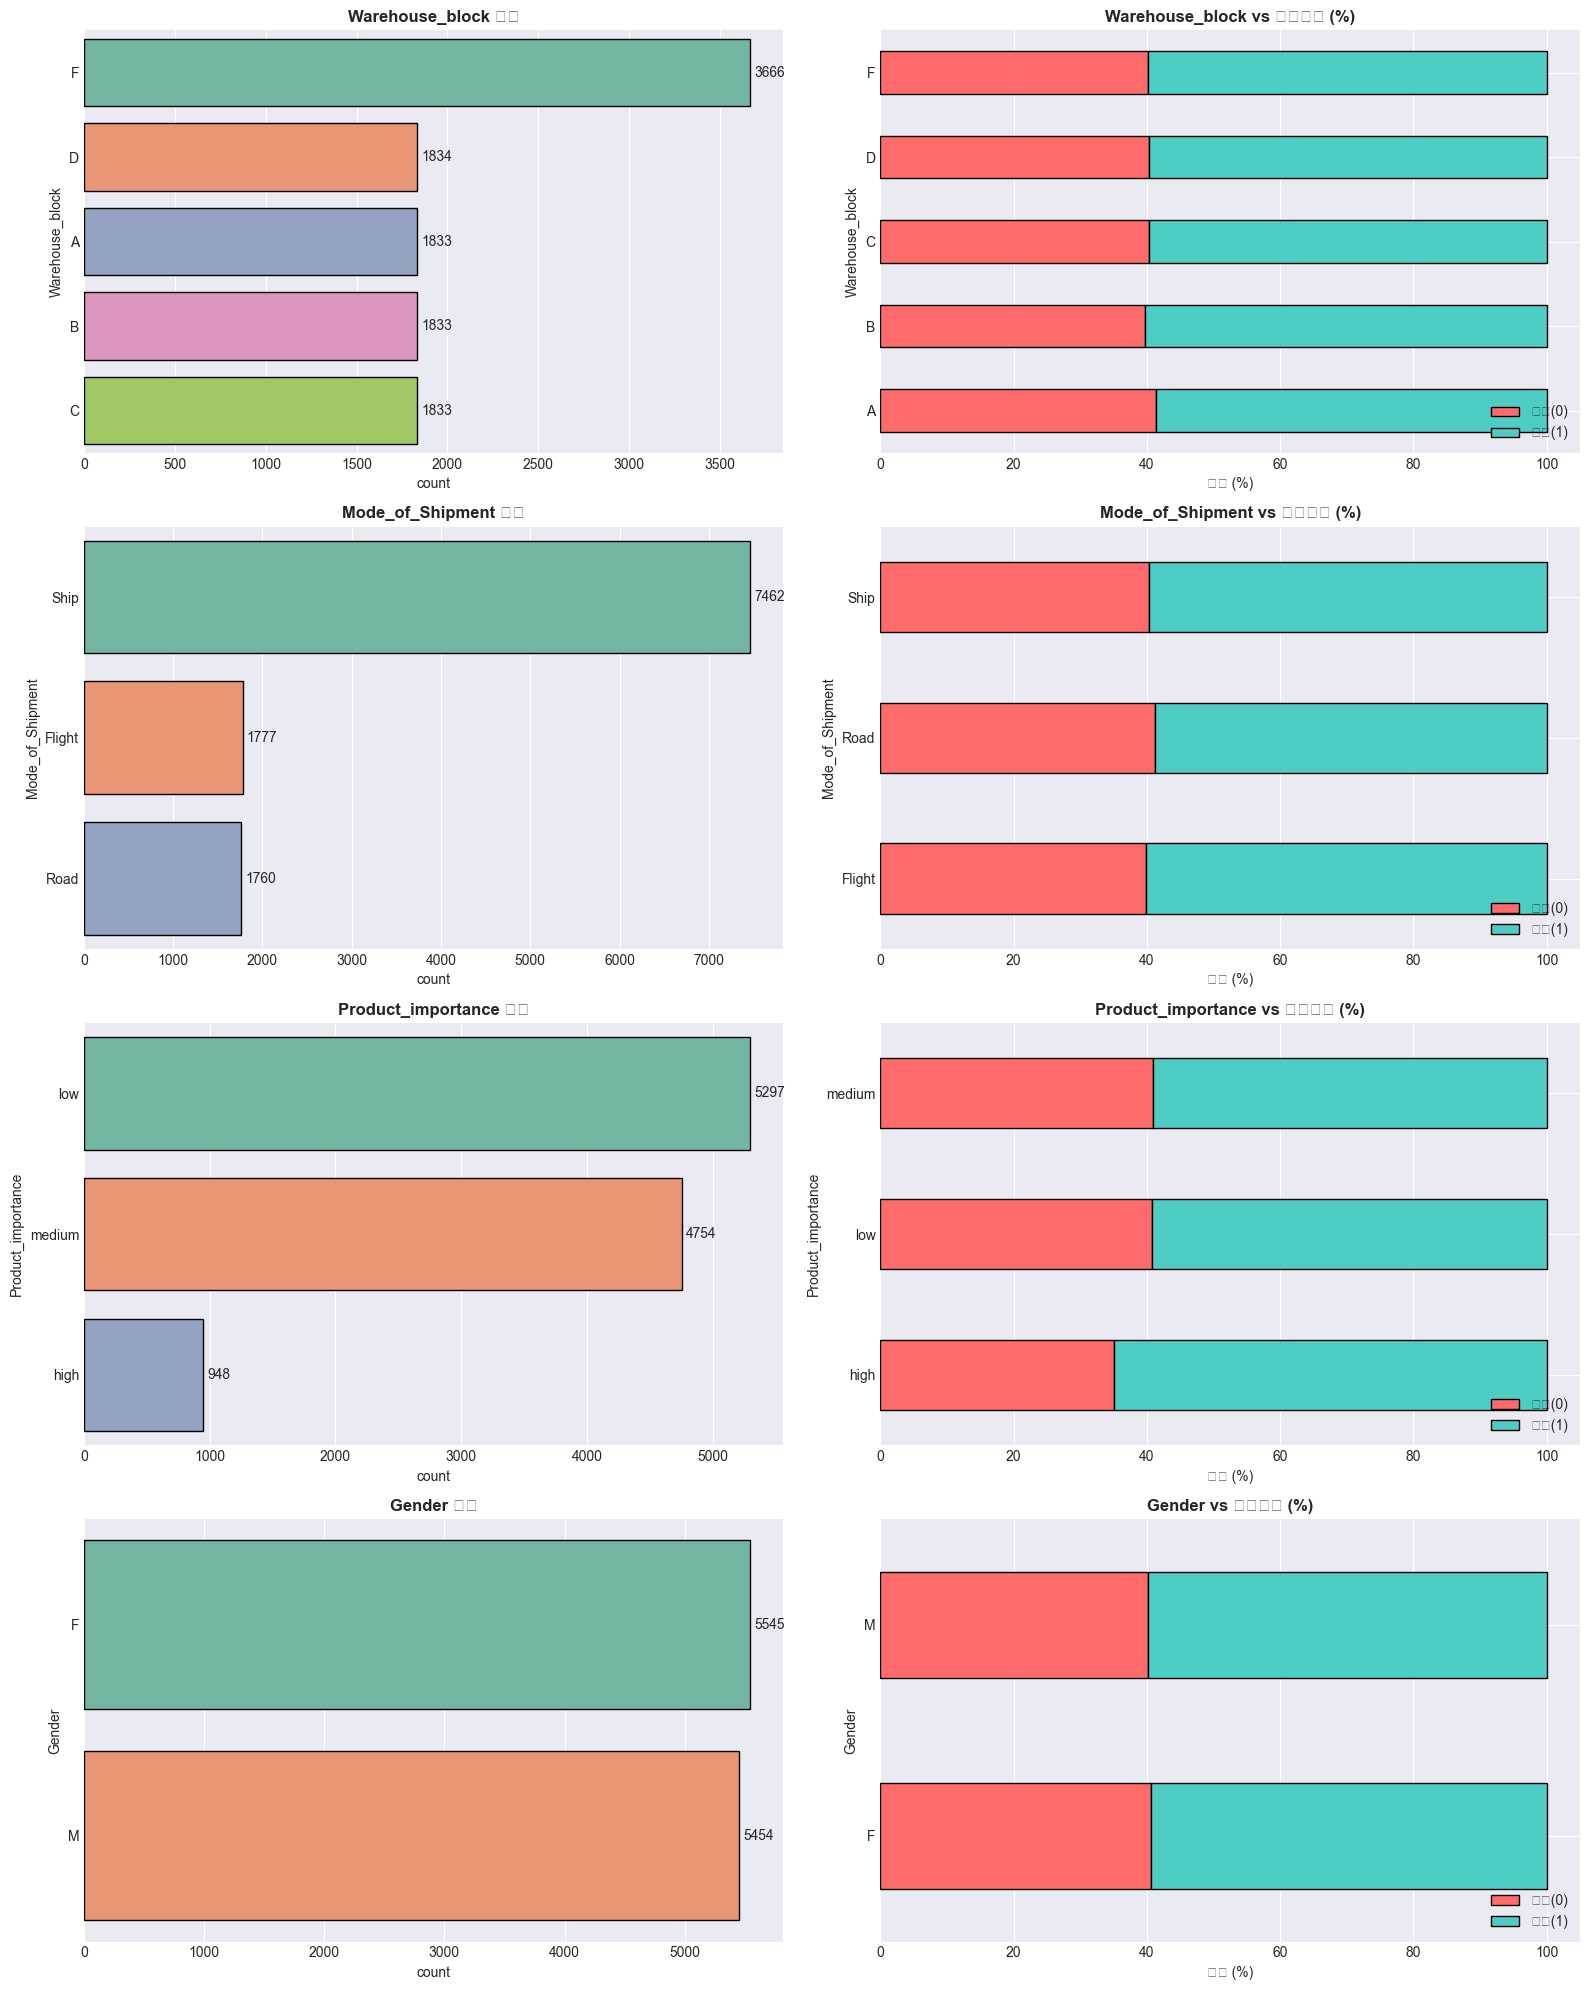

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"범주형 변수 ({len(categorical_cols)}개): {categorical_cols}")

# 범주형 분포 + 타겟 비율
fig, axes = plt.subplots(len(categorical_cols), 2, figsize=(16, len(categorical_cols) * 5))

for idx, col in enumerate(categorical_cols):
    # 좌: 분포
    order = df[col].value_counts().index
    sns.countplot(data=df, y=col, order=order, ax=axes[idx, 0],
                  palette='Set2', edgecolor='black')
    axes[idx, 0].set_title(f'{col} 분포', fontsize=12, weight='bold')
    for container in axes[idx, 0].containers:
        axes[idx, 0].bar_label(container, padding=3)

    # 우: 타겟별 비율
    ct = pd.crosstab(df[col], df[target_col], normalize='index') * 100
    ct.plot(kind='barh', stacked=True, ax=axes[idx, 1], color=colors, edgecolor='black')
    axes[idx, 1].set_title(f'{col} vs 배송결과 (%)', fontsize=12, weight='bold')
    axes[idx, 1].set_xlabel('비율 (%)')
    axes[idx, 1].legend(['지연(0)', '정시(1)'], loc='lower right')

plt.tight_layout()
plt.show()


### 3.5 다변량 교차 분석


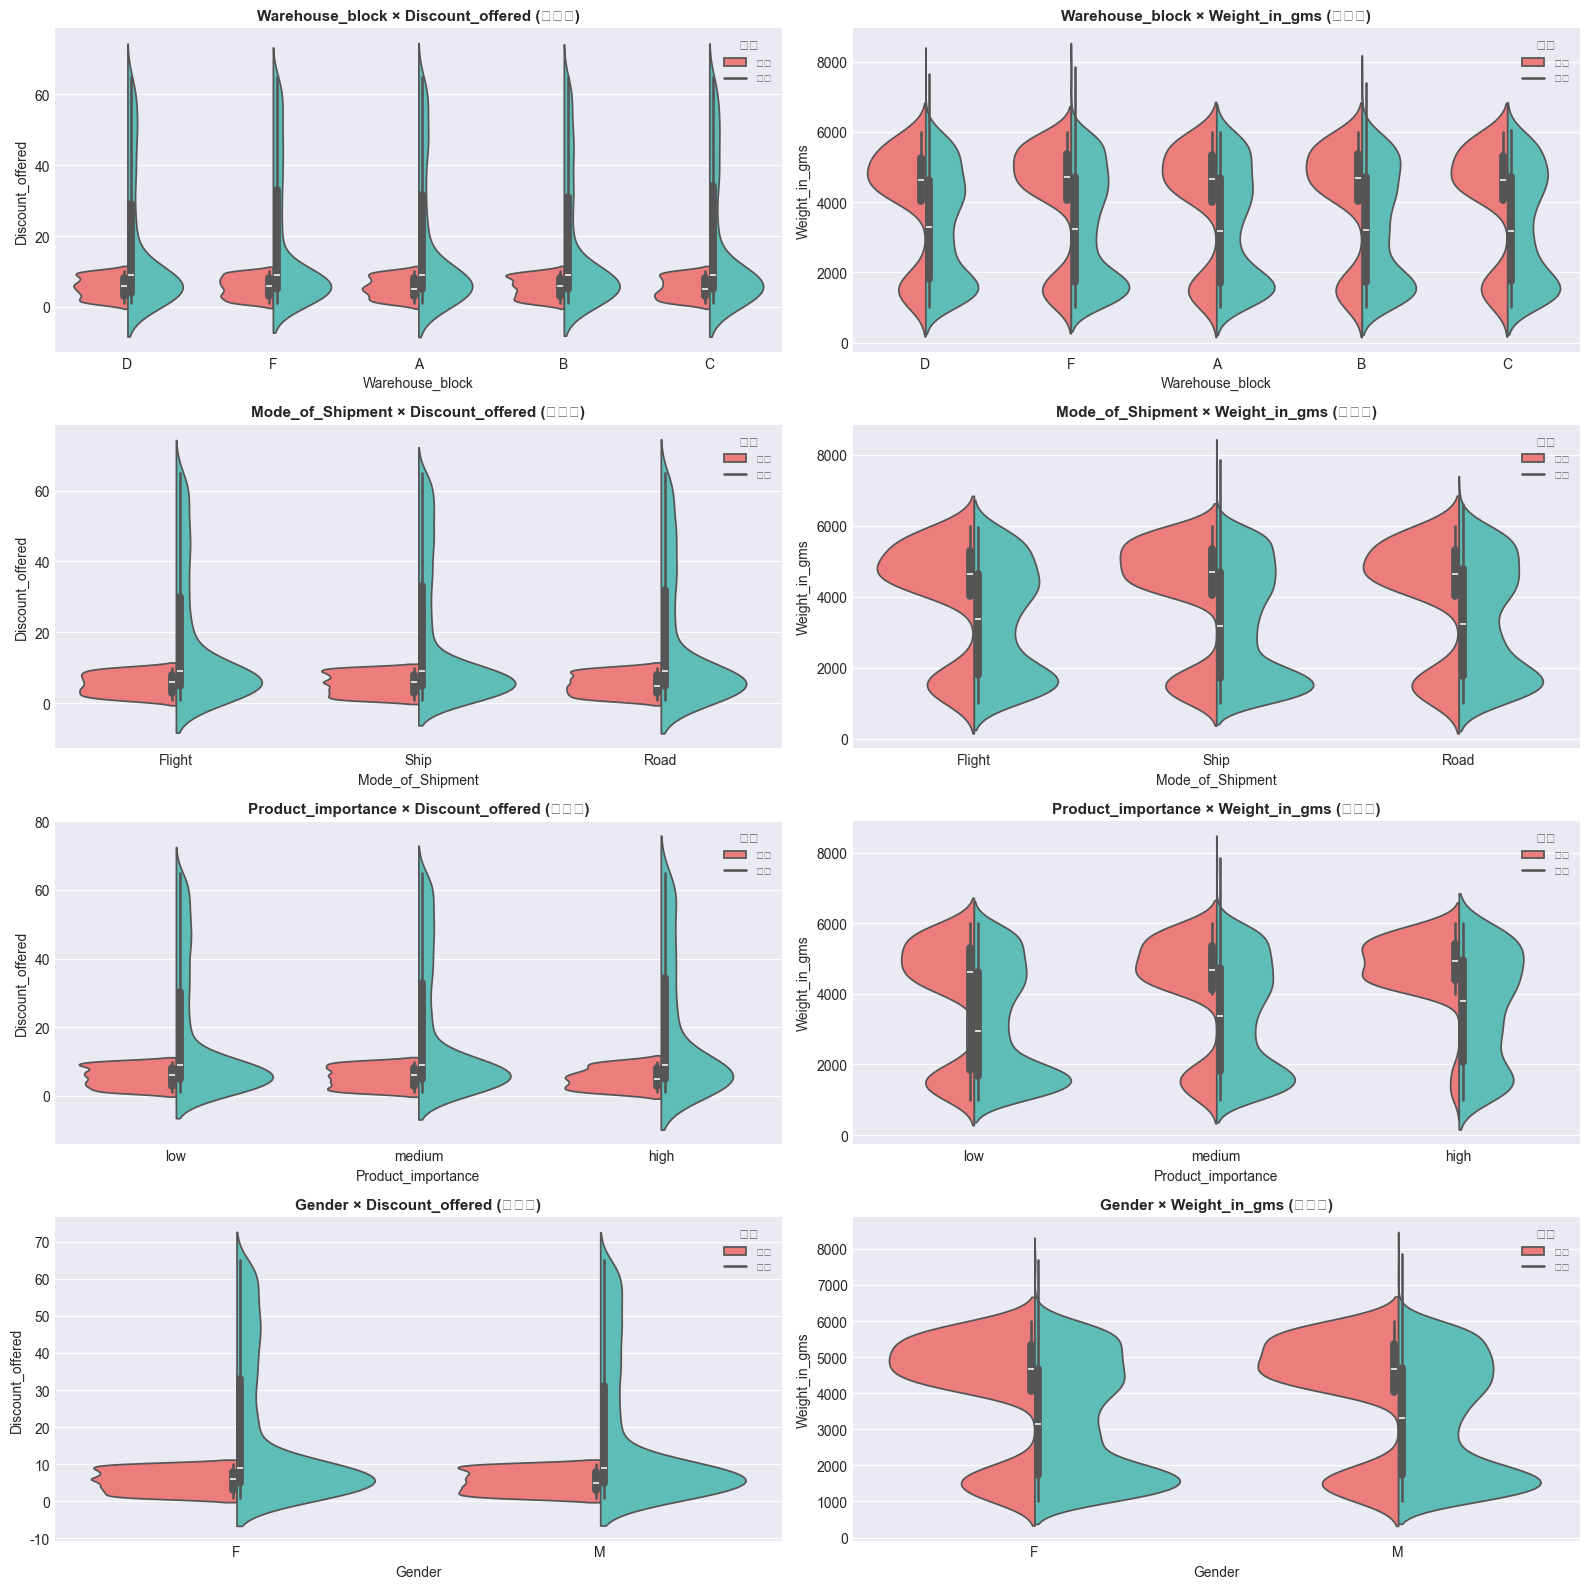

In [ ]:
# 수치형 × 범주형 × 타겟 — Violin Plot
fig, axes = plt.subplots(len(categorical_cols), 2, figsize=(16, len(categorical_cols) * 4))

for idx, cat_col in enumerate(categorical_cols):
    for j, num_col in enumerate(['Discount_offered', 'Weight_in_gms']):
        sns.violinplot(data=df, x=cat_col, y=num_col, hue=target_col,
                       split=True, palette=colors, ax=axes[idx, j], inner='box')
        axes[idx, j].set_title(f'{cat_col} × {num_col} (타겟별)', fontsize=11, weight='bold')
        axes[idx, j].legend(title='배송', labels=['지연', '정시'], fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px

# 샘플링
sample = df.sample(min(3000, len(df)), random_state=42)

# 수정 부분: color 파라미터에 replace 제거
fig = px.scatter(sample, x='Discount_offered', y='Weight_in_gms',
                 color=target_col,  # target_col 그대로 사용 ('Reached.on.Time_Y.N')
                 size='Cost_of_the_Product',
                 hover_data=['Mode_of_Shipment', 'Product_importance'],
                 title='할인율 vs 무게 vs 가격 (버블 크기=가격, 색상=배송결과)',
                 color_discrete_sequence=colors, opacity=0.6)

fig.update_layout(height=600, template='plotly_white')
fig.show()

In [ ]:
# Parallel Coordinates — 전체 수치형 변수
sample2 = df.sample(min(1000, len(df)), random_state=42)
fig = px.parallel_coordinates(
    sample2,
    dimensions=numeric_cols + [target_col],
    color=target_col,
    title='Parallel Coordinates (전체 수치형 변수)',
    color_continuous_scale=['#FF6B6B', '#4ECDC4']
)
fig.update_layout(height=600, template='plotly_white')
fig.show()


---
## 4. 전처리

> **요구사항 반영**:
> 1. 타겟변수 → **boolean** (정시=True, 지연=False)
> 2. object → **원핫인코딩**
> 3. int64 → **다운캐스팅** (메모리 효율)


In [ ]:
df_processed = df.copy()

print("🔧 전처리 시작...\n")

# ─── 0. ID 컬럼 제거 ───
if 'ID' in df_processed.columns:
    df_processed.drop(columns=['ID'], inplace=True)
    print("✅ ID 컬럼 제거")

# ─── 1. 타겟변수 → boolean (정시도착=True, 배송지연=False) ───
# 원본: 1=정시, 0=지연
df_processed[target_col] = df_processed[target_col].astype(bool)
# True = 정시도착(1), False = 배송지연(0)
print(f"✅ 타겟 → boolean 변환 완료")
print(f"   True(정시): {df_processed[target_col].sum():,}건")
print(f"   False(지연): {(~df_processed[target_col]).sum():,}건")

# ─── 2. 결측치 처리 ───
null_count = df_processed.isnull().sum().sum()
if null_count > 0:
    print(f"\n⚠️ 결측치 {null_count}건 → 중앙값/최빈값 대체")
    for col in df_processed.select_dtypes(include=[np.number]).columns:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)
    for col in df_processed.select_dtypes(include=['object']).columns:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
else:
    print("✅ 결측치 없음")

# ─── 3. 원핫인코딩 (object → dummies) ───
object_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
print(f"\n✅ 원핫인코딩 대상: {object_cols}")

df_processed = pd.get_dummies(df_processed, columns=object_cols, drop_first=False, dtype=np.int8)
print(f"   인코딩 후 컬럼 수: {df_processed.shape[1]}")

# ─── 4. int64 → 다운캐스팅 (효율성) ───
print("\n✅ 정수형 다운캐스팅:")
before_mem = df_processed.memory_usage(deep=True).sum() / 1024**2

for col in df_processed.select_dtypes(include=['int64', 'int32']).columns:
    col_min, col_max = df_processed[col].min(), df_processed[col].max()
    if col_min >= 0 and col_max <= 255:
        df_processed[col] = df_processed[col].astype(np.uint8)
    elif col_min >= -128 and col_max <= 127:
        df_processed[col] = df_processed[col].astype(np.int8)
    elif col_min >= 0 and col_max <= 65535:
        df_processed[col] = df_processed[col].astype(np.uint16)
    elif col_min >= -32768 and col_max <= 32767:
        df_processed[col] = df_processed[col].astype(np.int16)

after_mem = df_processed.memory_usage(deep=True).sum() / 1024**2
print(f"   메모리: {before_mem:.2f}MB → {after_mem:.2f}MB ({(1-after_mem/before_mem)*100:.1f}% 절감)")

print(f"\n📊 최종 데이터 타입 분포:")
print(df_processed.dtypes.value_counts())
print(f"\n전처리 완료! shape = {df_processed.shape}")
df_processed.head()


🔧 전처리 시작...

✅ ID 컬럼 제거
✅ 타겟 → boolean 변환 완료
   True(정시): 6,563건
   False(지연): 4,436건
✅ 결측치 없음

✅ 원핫인코딩 대상: ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
   인코딩 후 컬럼 수: 20

✅ 정수형 다운캐스팅:
   메모리: 0.65MB → 0.23MB (64.5% 절감)

📊 최종 데이터 타입 분포:
int8      13
uint8      4
uint16     2
bool       1
Name: count, dtype: int64

전처리 완료! shape = (10999, 20)


,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,4,2,177,3,44,1233,True,0,0,0,1,0,1,0,0,0,1,0,1,0
1,4,5,216,2,59,3088,True,0,0,0,0,1,1,0,0,0,1,0,0,1
2,2,2,183,4,48,3374,True,1,0,0,0,0,1,0,0,0,1,0,0,1
3,3,3,176,4,10,1177,True,0,1,0,0,0,1,0,0,0,0,1,0,1
4,2,2,184,3,46,2484,True,0,0,1,0,0,1,0,0,0,0,1,1,0


---
## 5. 특성 공학 — 파생변수 생성

> 도메인 지식 기반으로 **의미 있는 파생변수**를 생성합니다.


In [ ]:
print("🔧 파생변수 생성 시작...\n")

# ─── 1. 할인 구간 (binning) ───
bins = [0, 5, 15, 30, 50, 100]
labels_disc = ['0-5%', '6-15%', '16-30%', '31-50%', '51%+']
# 원본 df에서 생성 후 원핫
disc_bins = pd.cut(df['Discount_offered'], bins=bins, labels=labels_disc, include_lowest=True)
disc_dummies = pd.get_dummies(disc_bins, prefix='Discount_bin', dtype=np.int8)
df_processed = pd.concat([df_processed, disc_dummies], axis=1)
print(f"✅ 할인 구간 파생변수 ({len(labels_disc)}개): {list(disc_dummies.columns)}")

# ─── 2. 무게 구간 ───
weight_bins = [0, 1500, 3000, 4500, 7000]
labels_wt = ['경량', '보통', '중량', '초중량']
wt_bins = pd.cut(df['Weight_in_gms'], bins=weight_bins, labels=labels_wt, include_lowest=True)
wt_dummies = pd.get_dummies(wt_bins, prefix='Weight_bin', dtype=np.int8)
df_processed = pd.concat([df_processed, wt_dummies], axis=1)
print(f"✅ 무게 구간 파생변수 ({len(labels_wt)}개): {list(wt_dummies.columns)}")

# ─── 3. 가격 × 무게 상호작용 (배송 부담 지표) ───
df_processed['Cost_x_Weight'] = (df['Cost_of_the_Product'] * df['Weight_in_gms']).astype(np.int32)
print("✅ Cost_x_Weight (가격×무게 상호작용)")

# ─── 4. 할인율 × 가격 (실질 할인 금액 proxy) ───
df_processed['Discount_x_Cost'] = (df['Discount_offered'] * df['Cost_of_the_Product'] / 100).astype(np.int16)
print("✅ Discount_x_Cost (실질 할인 금액)")

# ─── 5. 고객 문의 대비 구매 경험 비율 ───
df_processed['Calls_per_Purchase'] = np.round(
    df['Customer_care_calls'] / (df['Prior_purchases'] + 1), 2
).astype(np.float32)
print("✅ Calls_per_Purchase (문의 횟수 / 구매 횟수)")

# ─── 6. 고가 상품 여부 ───
cost_median = df['Cost_of_the_Product'].median()
df_processed['Is_HighCost'] = (df['Cost_of_the_Product'] > cost_median).astype(np.int8)
print(f"✅ Is_HighCost (가격 > 중앙값 {cost_median})")

# ─── 7. 높은 할인율 플래그 ───
df_processed['Is_HighDiscount'] = (df['Discount_offered'] > 10).astype(np.int8)
print("✅ Is_HighDiscount (할인율 > 10%)")

# ─── 8. 단위 무게당 가격 ───
df_processed['Cost_per_gram'] = np.round(
    df['Cost_of_the_Product'] / (df['Weight_in_gms'] + 1), 4
).astype(np.float32)
print("✅ Cost_per_gram (단위 무게당 가격)")

# ─── 9. 고객 충성도 점수 (평점 × 이전구매) ───
df_processed['Loyalty_score'] = (df['Customer_rating'] * df['Prior_purchases']).astype(np.int16)
print("✅ Loyalty_score (평점 × 이전구매)")

print(f"\n📊 파생변수 생성 완료! 최종 shape = {df_processed.shape}")
print(f"💾 메모리: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
df_processed.head()


🔧 파생변수 생성 시작...

✅ 할인 구간 파생변수 (5개): ['Discount_bin_0-5%', 'Discount_bin_6-15%', 'Discount_bin_16-30%', 'Discount_bin_31-50%', 'Discount_bin_51%+']
✅ 무게 구간 파생변수 (4개): ['Weight_bin_경량', 'Weight_bin_보통', 'Weight_bin_중량', 'Weight_bin_초중량']
✅ Cost_x_Weight (가격×무게 상호작용)
✅ Discount_x_Cost (실질 할인 금액)
✅ Calls_per_Purchase (문의 횟수 / 구매 횟수)
✅ Is_HighCost (가격 > 중앙값 214.0)
✅ Is_HighDiscount (할인율 > 10%)
✅ Cost_per_gram (단위 무게당 가격)
✅ Loyalty_score (평점 × 이전구매)

📊 파생변수 생성 완료! 최종 shape = (10999, 36)
💾 메모리: 0.51 MB


,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M,Discount_bin_0-5%,Discount_bin_6-15%,Discount_bin_16-30%,Discount_bin_31-50%,Discount_bin_51%+,Weight_bin_경량,Weight_bin_보통,Weight_bin_중량,Weight_bin_초중량,Cost_x_Weight,Discount_x_Cost,Calls_per_Purchase,Is_HighCost,Is_HighDiscount,Cost_per_gram,Loyalty_score
0,4,2,177,3,44,1233,True,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,218241,77,1.00,0,1,0.1434,6
1,4,5,216,2,59,3088,True,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,667008,127,1.33,1,1,0.0699,10
2,2,2,183,4,48,3374,True,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,617442,87,0.40,0,1,0.0542,8
3,3,3,176,4,10,1177,True,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,207152,17,0.60,0,0,0.1494,12
4,2,2,184,3,46,2484,True,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,457056,84,0.50,0,1,0.0740,6


### 데이터 분할 & 스케일링


In [ ]:
# 특성 / 타겟 분리
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col].astype(int)  # sklearn은 int 필요

print(f"특성 수: {X.shape[1]}")
print(f"샘플 수: {X.shape[0]:,}")

# Train / Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain: {X_train.shape[0]:,}  |  Test: {X_test.shape[0]:,}")
print(f"Train 타겟 비율: {y_train.mean():.4f}")
print(f"Test  타겟 비율: {y_test.mean():.4f}")

# 스케일링 (LR, SVM 등에 사용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\n✅ StandardScaler 적용 완료")


특성 수: 35
샘플 수: 10,999

Train: 8,799  |  Test: 2,200
Train 타겟 비율: 0.5967
Test  타겟 비율: 0.5968

✅ StandardScaler 적용 완료


---
## 6. 베이스라인 모델 비교 (8개 알고리즘)


In [ ]:
baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, n_estimators=100,
                              eval_metric='logloss', verbosity=0),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE, n_estimators=100, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, iterations=100, verbose=0)
}

# 스케일링이 필요한 모델
scale_models = {'Logistic Regression', 'KNN'}

baseline_results = []

for name, model in baseline_models.items():
    X_tr = X_train_scaled if name in scale_models else X_train
    X_te = X_test_scaled if name in scale_models else X_test

    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]

    res = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    baseline_results.append(res)
    print(f"✅ {name:25s} | F1={res['F1-Score']:.4f} | AUC={res['ROC-AUC']:.4f}")

results_df = pd.DataFrame(baseline_results).sort_values('F1-Score', ascending=False)
print("\n" + "=" * 60)
print(results_df.to_string(index=False))


✅ Logistic Regression       | F1=0.6695 | AUC=0.7450
✅ KNN                       | F1=0.6421 | AUC=0.7050
✅ Decision Tree             | F1=0.6409 | AUC=0.6262
✅ Random Forest             | F1=0.6576 | AUC=0.7297
✅ Gradient Boosting         | F1=0.6738 | AUC=0.7475
✅ XGBoost                   | F1=0.6438 | AUC=0.7279
✅ LightGBM                  | F1=0.6577 | AUC=0.7320
✅ CatBoost                  | F1=0.6644 | AUC=0.7447

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
  Gradient Boosting  0.677273   0.753894 0.677273  0.673758 0.747544
Logistic Regression  0.667727   0.706609 0.667727  0.669459 0.745008
           CatBoost  0.661818   0.692485 0.661818  0.664418 0.744690
           LightGBM  0.655000   0.684509 0.655000  0.657740 0.731984
      Random Forest  0.654545   0.680345 0.654545  0.657567 0.729702
            XGBoost  0.640455   0.655103 0.640455  0.643761 0.727889
                KNN  0.640000   0.645733 0.640000  0.642071 0.705013
      Decision Tree  0.

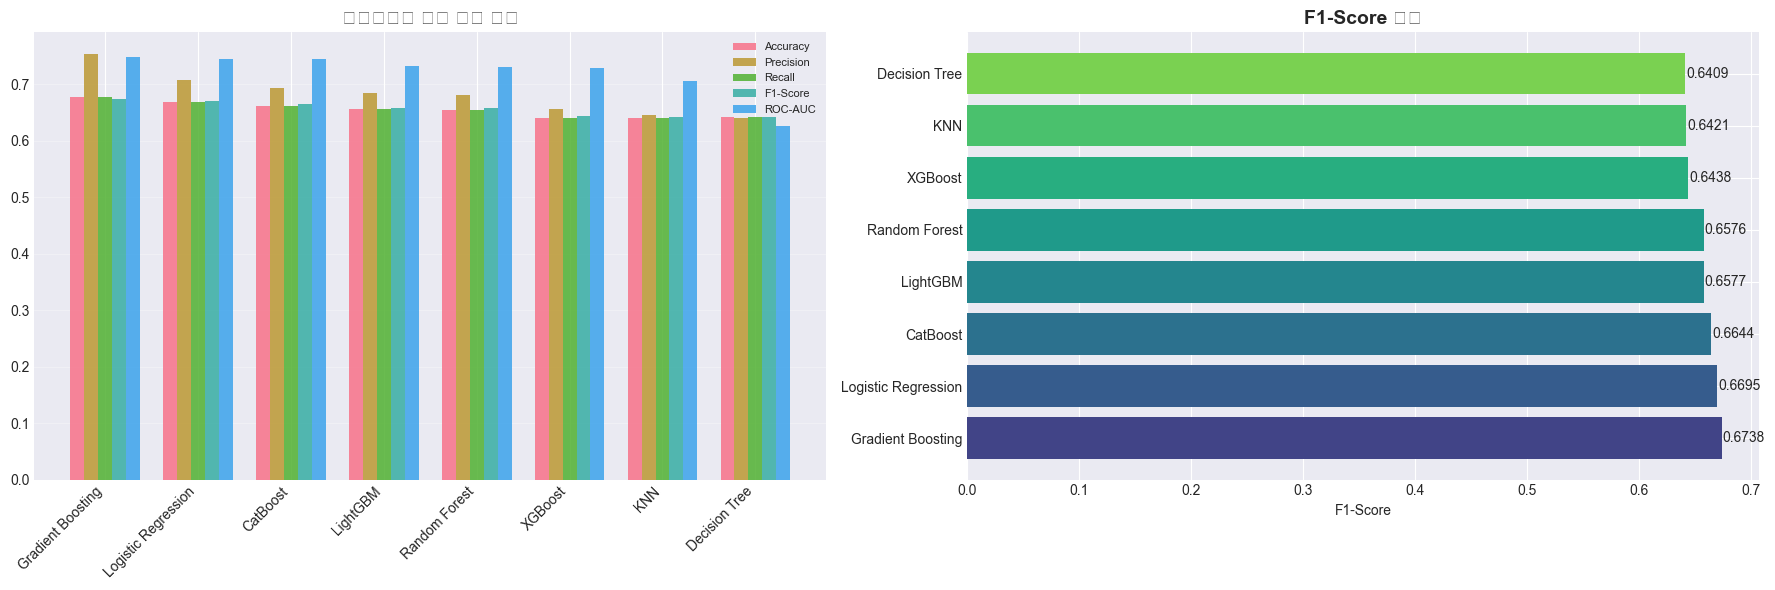

In [ ]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 멀티 메트릭 바 차트
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(results_df))
width = 0.15
for i, m in enumerate(metrics):
    axes[0].bar(x + i*width, results_df[m], width, label=m, alpha=0.85)
axes[0].set_xticks(x + width*2)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].set_title('베이스라인 모델 성능 비교', fontsize=14, weight='bold')
axes[0].legend(fontsize=8)
axes[0].grid(axis='y', alpha=0.3)

# F1 순위
colors_bar = plt.cm.viridis(np.linspace(0.2, 0.8, len(results_df)))
axes[1].barh(results_df['Model'], results_df['F1-Score'], color=colors_bar)
axes[1].set_xlabel('F1-Score')
axes[1].set_title('F1-Score 순위', fontsize=14, weight='bold')
for i, v in enumerate(results_df['F1-Score']):
    axes[1].text(v + 0.001, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()


---
## 7. Optuna 하이퍼파라미터 튜닝

> 상위 3개 모델에 대해 **Optuna**로 최적 파라미터를 탐색합니다.


In [ ]:
top_models = results_df.head(3)['Model'].tolist()
print(f"🎯 튜닝 대상: {top_models}")


🎯 튜닝 대상: ['Gradient Boosting', 'Logistic Regression', 'CatBoost']


### 7.1 XGBoost Optuna 튜닝


In [ ]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
        'random_state': RANDOM_STATE,
        'eval_metric': 'logloss',
        'verbosity': 0
    }
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
    return scores.mean()

study_xgb = optuna.create_study(direction='maximize', study_name='XGBoost')
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

print(f"\n✅ XGBoost 최적 F1: {study_xgb.best_value:.4f}")
for k, v in study_xgb.best_params.items():
    print(f"   {k}: {v}")


Best trial: 46. Best value: 0.680735: 100%|██████████| 50/50 [01:55<00:00,  2.31s/it]


✅ XGBoost 최적 F1: 0.6807
   n_estimators: 130
   max_depth: 3
   learning_rate: 0.023818944940429364
   subsample: 0.9510708682519968
   colsample_bytree: 0.7918287073797085
   min_child_weight: 8
   gamma: 0.03705890673222012
   reg_alpha: 0.012557819439952758
   reg_lambda: 0.4402331364538074


In [ ]:
# Optuna 시각화
fig1 = plot_optimization_history(study_xgb)
fig1.update_layout(title='XGBoost 최적화 히스토리', height=400)
fig1.show()

fig2 = plot_param_importances(study_xgb)
fig2.update_layout(title='XGBoost 파라미터 중요도', height=400)
fig2.show()


### 7.2 LightGBM Optuna 튜닝


In [ ]:
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
        'random_state': RANDOM_STATE,
        'verbose': -1
    }
    model = LGBMClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
    return scores.mean()

study_lgbm = optuna.create_study(direction='maximize', study_name='LightGBM')
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)

print(f"\n✅ LightGBM 최적 F1: {study_lgbm.best_value:.4f}")
for k, v in study_lgbm.best_params.items():
    print(f"   {k}: {v}")


Best trial: 11. Best value: 0.679214: 100%|██████████| 50/50 [04:31<00:00,  5.44s/it]


✅ LightGBM 최적 F1: 0.6792
   n_estimators: 345
   max_depth: 3
   learning_rate: 0.011017140305006876
   num_leaves: 64
   subsample: 0.9906478757883519
   colsample_bytree: 0.604734097050381
   min_child_samples: 64
   reg_alpha: 0.18618966912651377
   reg_lambda: 0.001272417516983849


### 7.3 CatBoost Optuna 튜닝


In [ ]:
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 800),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'random_state': RANDOM_STATE,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    for tr_idx, val_idx in skf.split(X_train, y_train):
        model.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx], verbose=False)
        pred = model.predict(X_train.iloc[val_idx])
        scores.append(f1_score(y_train.iloc[val_idx], pred, average='weighted'))
    return np.mean(scores)

study_cat = optuna.create_study(direction='maximize', study_name='CatBoost')
study_cat.optimize(objective_catboost, n_trials=50, show_progress_bar=True)

print(f"\n✅ CatBoost 최적 F1: {study_cat.best_value:.4f}")
for k, v in study_cat.best_params.items():
    print(f"   {k}: {v}")


Best trial: 12. Best value: 0.676998: 100%|██████████| 50/50 [24:17<00:00, 29.15s/it]


✅ CatBoost 최적 F1: 0.6770
   iterations: 103
   depth: 10
   learning_rate: 0.011360107124460818
   l2_leaf_reg: 1.1637074178669418
   border_count: 118
   bagging_temperature: 0.23761711498967794
   random_strength: 0.9816982625286212


---
## 8. 모델 평가

### 8.1 최적 모델 학습 & 비교


In [ ]:
# 최적 파라미터로 학습
best_xgb = XGBClassifier(**study_xgb.best_params, eval_metric='logloss', verbosity=0)
best_xgb.fit(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

best_lgbm = LGBMClassifier(**study_lgbm.best_params, verbose=-1)
best_lgbm.fit(X_train, y_train)
y_pred_lgbm = best_lgbm.predict(X_test)
y_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

best_cat = CatBoostClassifier(**study_cat.best_params, verbose=0)
best_cat.fit(X_train, y_train)
y_pred_cat = best_cat.predict(X_test)
y_proba_cat = best_cat.predict_proba(X_test)[:, 1]

# 앙상블 (Soft Voting)
ensemble = VotingClassifier(
    estimators=[('xgb', best_xgb), ('lgbm', best_lgbm), ('cat', best_cat)],
    voting='soft'
)
ensemble.fit(X_train, y_train)
y_pred_ens = ensemble.predict(X_test)
y_proba_ens = ensemble.predict_proba(X_test)[:, 1]

# 결과 정리
final_results = []
for name, yp, ypp in [
    ('XGBoost (Tuned)', y_pred_xgb, y_proba_xgb),
    ('LightGBM (Tuned)', y_pred_lgbm, y_proba_lgbm),
    ('CatBoost (Tuned)', y_pred_cat, y_proba_cat),
    ('Voting Ensemble', y_pred_ens, y_proba_ens),
]:
    final_results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, yp),
        'Precision': precision_score(y_test, yp, average='weighted'),
        'Recall': recall_score(y_test, yp, average='weighted'),
        'F1-Score': f1_score(y_test, yp, average='weighted'),
        'ROC-AUC': roc_auc_score(y_test, ypp)
    })

final_df = pd.DataFrame(final_results).sort_values('F1-Score', ascending=False)
print("🏆 튜닝 후 최종 성능:\n")
print(final_df.to_string(index=False))


🏆 튜닝 후 최종 성능:

           Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
CatBoost (Tuned)  0.683182   0.781862 0.683182  0.676561 0.744050
 Voting Ensemble  0.679091   0.795367 0.679091  0.669573 0.752296
 XGBoost (Tuned)  0.679545   0.799527 0.679545  0.669506 0.753771
LightGBM (Tuned)  0.676818   0.796824 0.676818  0.666571 0.756991


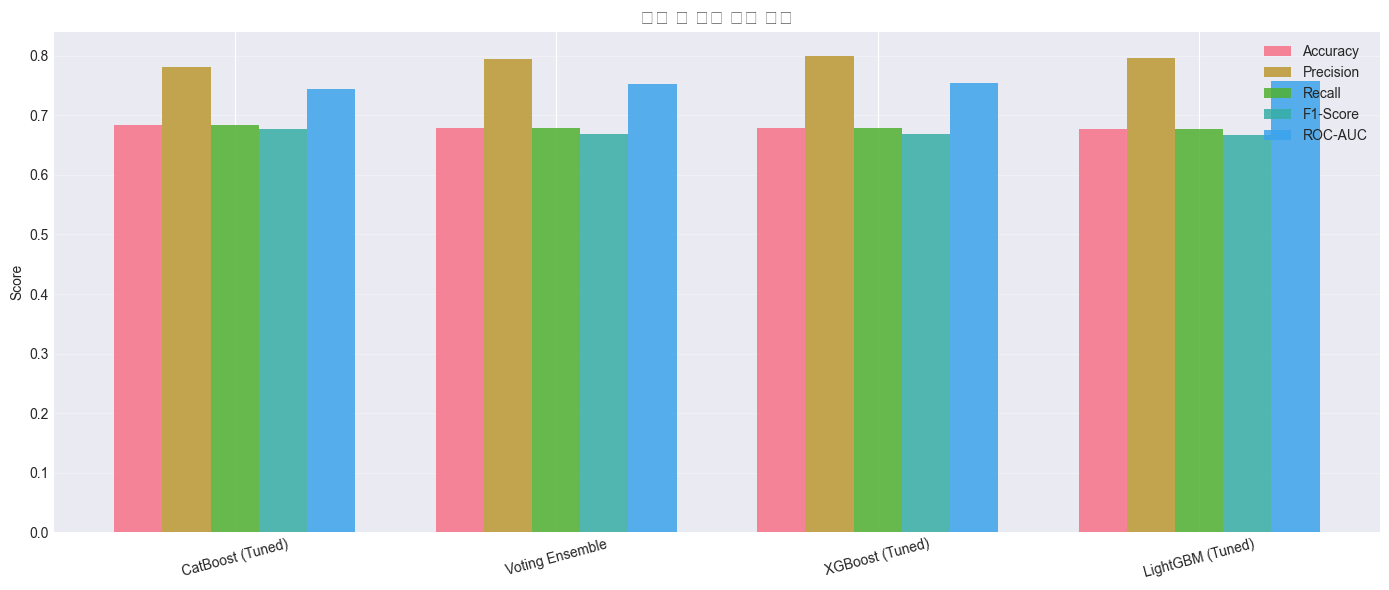

In [ ]:
# 성능 시각화
fig, ax = plt.subplots(figsize=(14, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(final_df))
width = 0.15

for i, m in enumerate(metrics):
    ax.bar(x + i*width, final_df[m], width, label=m, alpha=0.85)

ax.set_xticks(x + width*2)
ax.set_xticklabels(final_df['Model'], rotation=15)
ax.set_title('튜닝 후 최종 모델 성능', fontsize=14, weight='bold')
ax.set_ylabel('Score')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### 8.2 최고 모델 상세 평가


🏆 최고 모델: CatBoost (Tuned)



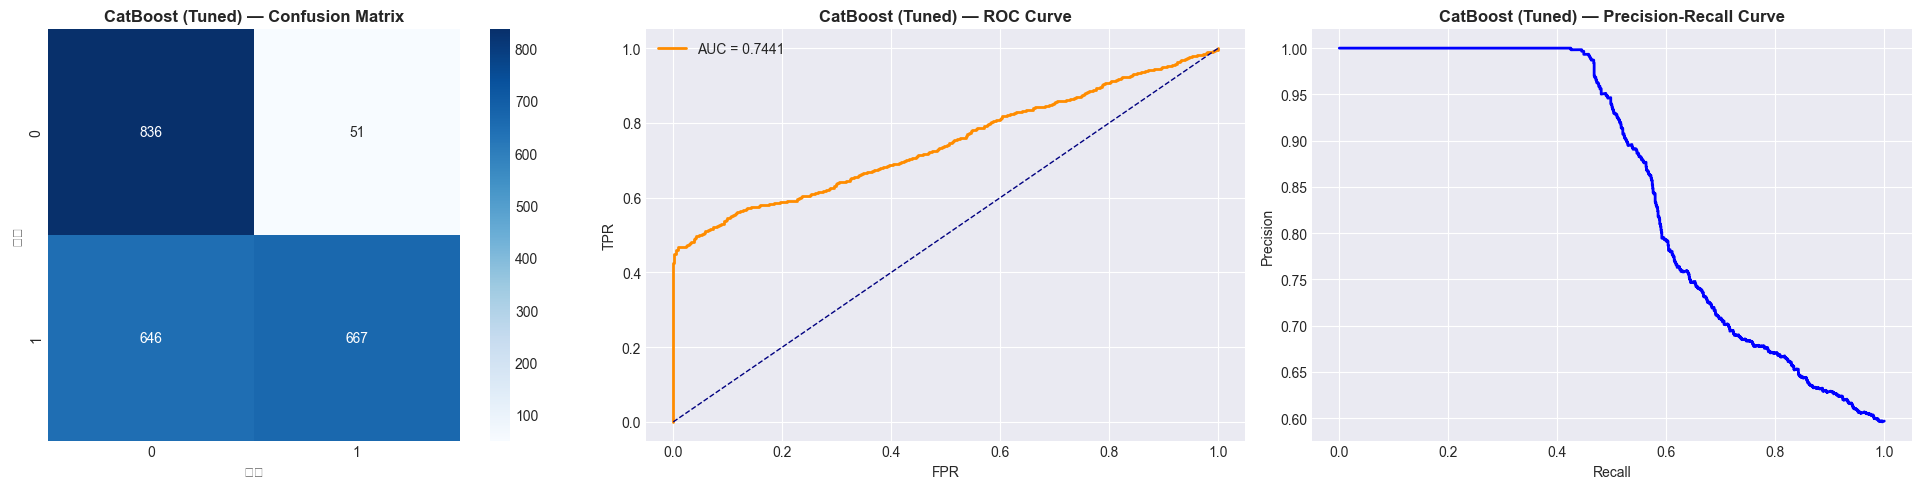


📋 Classification Report:

              precision    recall  f1-score   support

       지연(0)       0.56      0.94      0.71       887
       정시(1)       0.93      0.51      0.66      1313

    accuracy                           0.68      2200
   macro avg       0.75      0.73      0.68      2200
weighted avg       0.78      0.68      0.68      2200



In [ ]:
# 최고 모델 자동 선택
best_name = final_df.iloc[0]['Model']
print(f"🏆 최고 모델: {best_name}\n")

model_map = {
    'XGBoost (Tuned)': (best_xgb, y_pred_xgb, y_proba_xgb),
    'LightGBM (Tuned)': (best_lgbm, y_pred_lgbm, y_proba_lgbm),
    'CatBoost (Tuned)': (best_cat, y_pred_cat, y_proba_cat),
    'Voting Ensemble': (ensemble, y_pred_ens, y_proba_ens),
}
best_model, y_pred_best, y_proba_best = model_map[best_name]

# Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], square=True)
axes[0].set_title(f'{best_name} — Confusion Matrix', weight='bold')
axes[0].set_ylabel('실제'); axes[0].set_xlabel('예측')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
auc_val = roc_auc_score(y_test, y_proba_best)
axes[1].plot(fpr, tpr, 'darkorange', lw=2, label=f'AUC = {auc_val:.4f}')
axes[1].plot([0,1], [0,1], 'navy', lw=1, ls='--')
axes[1].set_title(f'{best_name} — ROC Curve', weight='bold')
axes[1].set_xlabel('FPR'); axes[1].set_ylabel('TPR')
axes[1].legend()

# PR Curve
prec_c, rec_c, _ = precision_recall_curve(y_test, y_proba_best)
axes[2].plot(rec_c, prec_c, 'blue', lw=2)
axes[2].set_title(f'{best_name} — Precision-Recall Curve', weight='bold')
axes[2].set_xlabel('Recall'); axes[2].set_ylabel('Precision')

plt.tight_layout()
plt.show()

print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred_best, target_names=['지연(0)', '정시(1)']))


### 8.3 특성 중요도


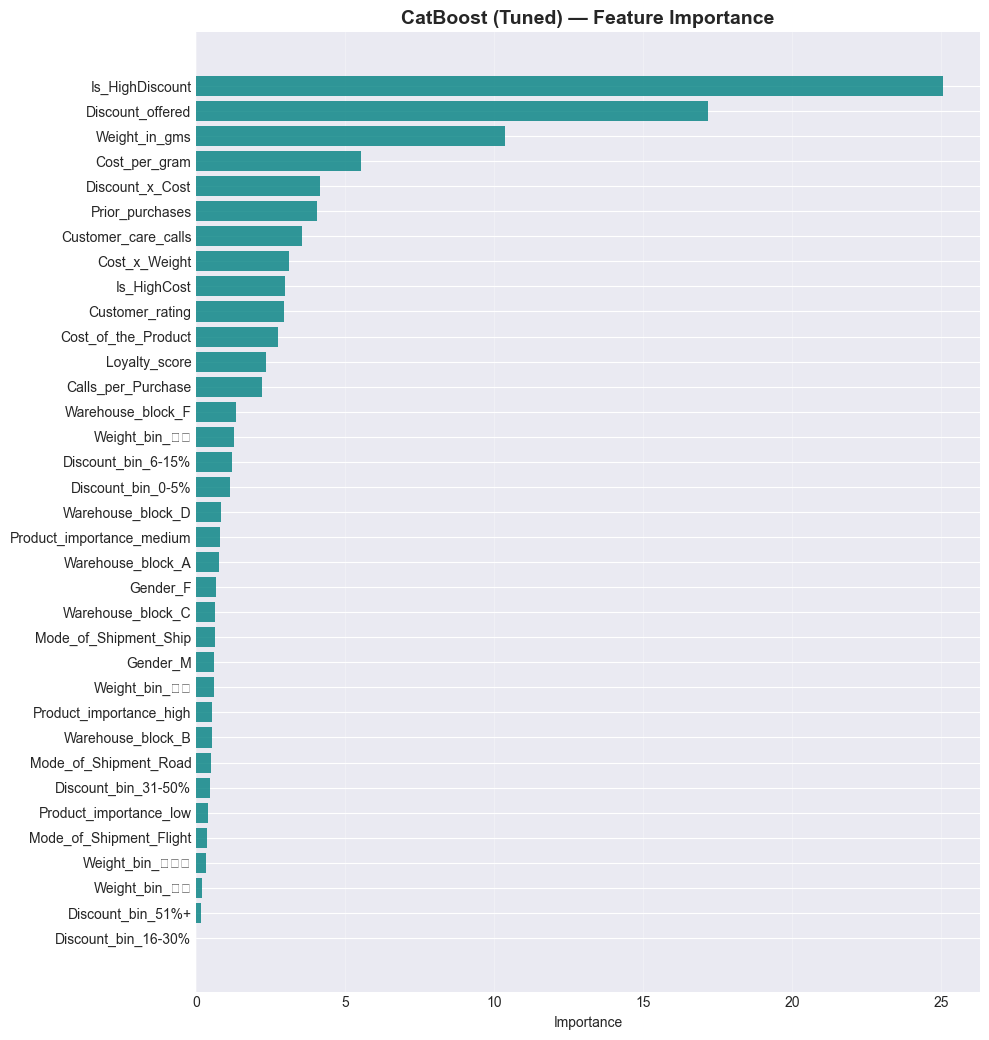


📊 Top 10 중요 특성:
            feature  importance
    Is_HighDiscount   25.052059
   Discount_offered   17.166909
      Weight_in_gms   10.350801
      Cost_per_gram    5.529338
    Discount_x_Cost    4.163906
    Prior_purchases    4.060679
Customer_care_calls    3.550052
      Cost_x_Weight    3.107582
        Is_HighCost    2.990068
    Customer_rating    2.943266


In [ ]:
# Feature Importance (tree 모델)
if hasattr(best_model, 'feature_importances_'):
    fi = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)

    plt.figure(figsize=(10, max(6, len(fi)*0.3)))
    plt.barh(fi['feature'], fi['importance'], color='teal', alpha=0.8)
    plt.xlabel('Importance')
    plt.title(f'{best_name} — Feature Importance', fontsize=14, weight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n📊 Top 10 중요 특성:")
    print(fi.tail(10).iloc[::-1][['feature','importance']].to_string(index=False))
elif hasattr(best_model, 'estimators_'):
    # VotingClassifier인 경우 XGBoost 기준
    fi = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_xgb.feature_importances_
    }).sort_values('importance', ascending=True)

    plt.figure(figsize=(10, max(6, len(fi)*0.3)))
    plt.barh(fi['feature'], fi['importance'], color='teal', alpha=0.8)
    plt.xlabel('Importance')
    plt.title('XGBoost (Tuned) — Feature Importance', fontsize=14, weight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


### 8.4 SHAP 분석


🔍 SHAP 값 계산 중...



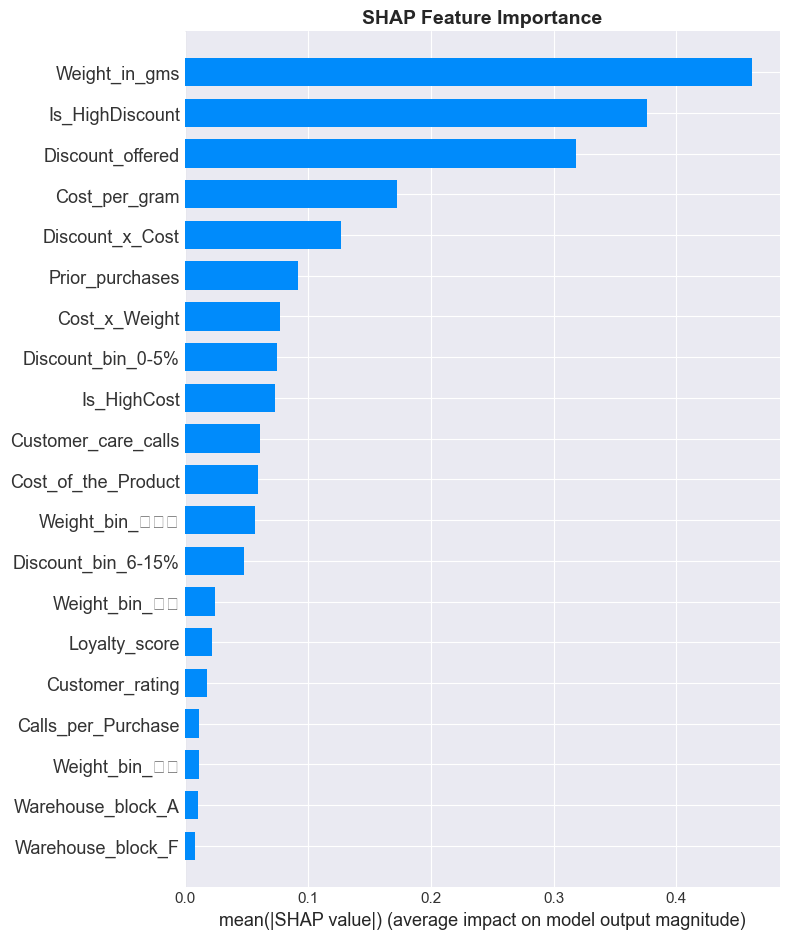

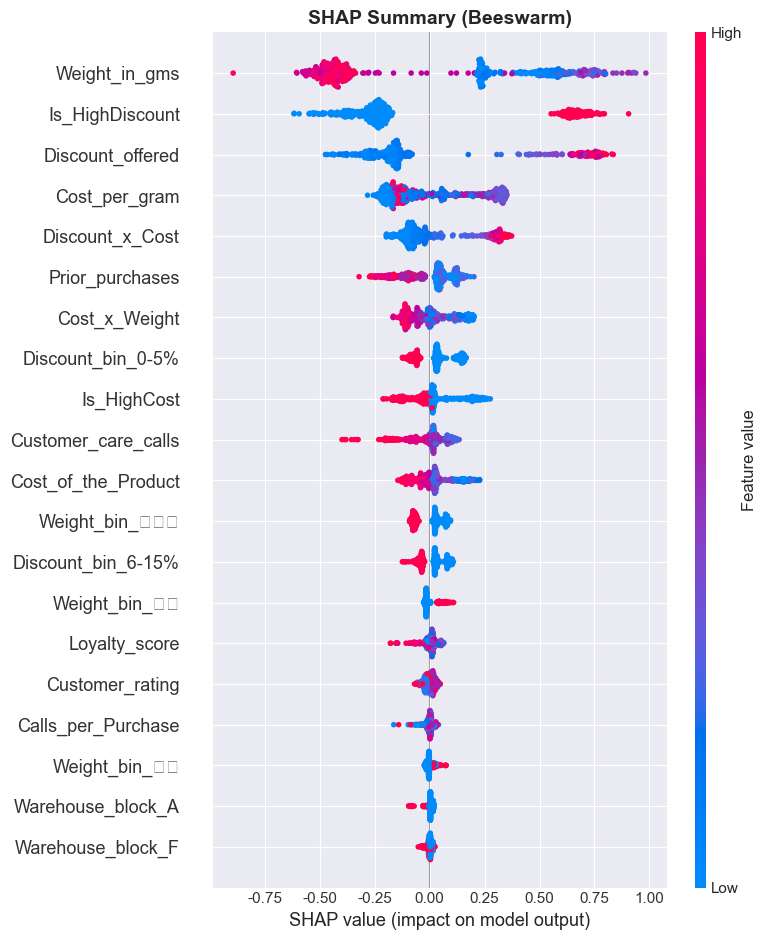

✅ SHAP 분석 완료!


In [ ]:
if SHAP_AVAILABLE:
    print("🔍 SHAP 값 계산 중...\n")

    # tree model 선택 (ensemble이면 xgb 사용)
    shap_model = best_xgb if isinstance(best_model, VotingClassifier) else best_model
    explainer = shap.TreeExplainer(shap_model)

    sample_size = min(500, len(X_test))
    X_sample = X_test.sample(sample_size, random_state=RANDOM_STATE)
    shap_values = explainer.shap_values(X_sample)

    # Bar Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

    # Beeswarm
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title('SHAP Summary (Beeswarm)', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

    print("✅ SHAP 분석 완료!")
else:
    print("⚠️ SHAP 미설치 — 섹션 건너뜀")
    print("  설치: pip install shap")


---
## 9. 전체 결과 요약


In [ ]:
# 베이스라인 + 튜닝 통합
all_results = pd.concat([results_df, final_df], ignore_index=True)
all_results = all_results.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("=" * 80)
print("🏆 전체 모델 성능 종합 (F1 순)")
print("=" * 80)
print(all_results.to_string(index=False))

print(f"\n🥇 최종 선택: {all_results.iloc[0]['Model']}")
print(f"   F1={all_results.iloc[0]['F1-Score']:.4f}  |  AUC={all_results.iloc[0]['ROC-AUC']:.4f}")


🏆 전체 모델 성능 종합 (F1 순)
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
   CatBoost (Tuned)  0.683182   0.781862 0.683182  0.676561 0.744050
  Gradient Boosting  0.677273   0.753894 0.677273  0.673758 0.747544
    Voting Ensemble  0.679091   0.795367 0.679091  0.669573 0.752296
    XGBoost (Tuned)  0.679545   0.799527 0.679545  0.669506 0.753771
Logistic Regression  0.667727   0.706609 0.667727  0.669459 0.745008
   LightGBM (Tuned)  0.676818   0.796824 0.676818  0.666571 0.756991
           CatBoost  0.661818   0.692485 0.661818  0.664418 0.744690
           LightGBM  0.655000   0.684509 0.655000  0.657740 0.731984
      Random Forest  0.654545   0.680345 0.654545  0.657567 0.729702
            XGBoost  0.640455   0.655103 0.640455  0.643761 0.727889
                KNN  0.640000   0.645733 0.640000  0.642071 0.705013
      Decision Tree  0.641364   0.640527 0.641364  0.640923 0.626204

🥇 최종 선택: CatBoost (Tuned)
   F1=0.6766  |  AUC=0.7441


In [ ]:
# 인터랙티브 종합 비교
fig = go.Figure()
for m in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    fig.add_trace(go.Bar(name=m, x=all_results['Model'], y=all_results[m],
                         text=all_results[m].round(4), textposition='auto'))
fig.update_layout(title='전체 모델 성능 비교', barmode='group',
                  height=600, template='plotly_white',
                  xaxis={'tickangle': 45})
fig.show()


---
## 10. 모델 저장


In [ ]:
import joblib

joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("✅ 모델 저장 완료!")
print("  - best_model.pkl")
print("  - scaler.pkl")


✅ 모델 저장 완료!
  - best_model.pkl
  - scaler.pkl


---
## 11. 결론

### ✅ 수행 내역
1. **데이터셋 소개** — 컬럼별 상세 설명
2. **라이브러리 & 데이터 로딩** — 다중 경로 지원
3. **EDA** — 타겟별 박스플롯, Pairplot, 범주형×수치형 Violin, 히트맵, Plotly 인터랙티브
4. **전처리** — 타겟 boolean 변환, 원핫인코딩, int 다운캐스팅
5. **특성 공학** — 9개 파생변수 생성 (할인/무게 구간, 상호작용, 비율 등)
6. **모델링** — 8개 베이스라인 + Optuna 튜닝 3개 + 앙상블
7. **하이퍼파라미터 튜닝** — Optuna 50 trials × 3 모델
8. **모델 평가** — Confusion Matrix, ROC, PR Curve, Feature Importance, SHAP
